# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [117]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

import random

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [118]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [119]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

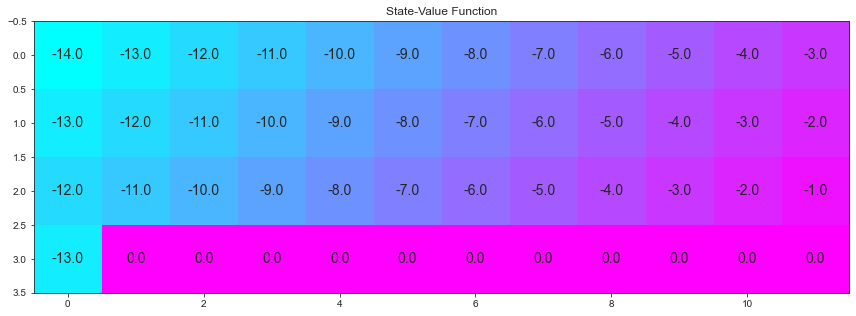

In [120]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [121]:
def decay_epsilon(eps_current, eps_decay, eps_min):
    eps_decayed = eps_current * eps_decay
    return eps_decayed if eps_decayed > eps_min else eps_min

In [122]:
def test_decay_epsilon():
    for eps_decay in [1, 0.5, 0.3, 0.1, 0.01]:
        eps_decayed = decay_epsilon(1.0, eps_decay, 0.1)
        print("eps_decayed(1.0, {eps_decay}, 0.1): {eps_decayed}".format(**locals()))

test_decay_epsilon()

eps_decayed(1.0, 1, 0.1): 1.0
eps_decayed(1.0, 0.5, 0.1): 0.5
eps_decayed(1.0, 0.3, 0.1): 0.3
eps_decayed(1.0, 0.1, 0.1): 0.1
eps_decayed(1.0, 0.01, 0.1): 0.1


In [123]:
def get_action_with_highest_reward(actions):
    # Return the index with highest value.
    # Note: This returns the index, whereas np.amax returns the actual max value.
    return np.argmax(actions);

In [124]:
def test_get_action_with_highest_reward():
    stateActionDict = { 3: [-0.9, -1.0, -5.0, -10.0], 6: [-0.4, -0.2, -0.3, -0.25], 12: [1, 10, 15, 13], 16: [3, 8, 2, 10], 20: [10, 1, 2, 5]  }
    for i, key in enumerate(stateActionDict):
        best_action = get_action_with_highest_reward(stateActionDict[key])
        print("key: ", key, ", best action: ", best_action)

test_get_action_with_highest_reward()

key:  3 , best action:  0
key:  6 , best action:  1
key:  12 , best action:  2
key:  16 , best action:  3
key:  20 , best action:  0


In [125]:
# Return an array of nA+1 elements, in terms of probability of choosing the following actions:
#   [0] - probability of choosing Action 0 (epsilon / nA)
#   [nA-1] - probability of choosing Action nA-1 (epsilon / nA)
#   [nA] - probability of choosing the Best Action (1 - epsilon)
def get_probabilities_epsilon_greedy(epsilon, nA):
    # 1 - epsilon = action with highest rewards for the state
    # epsilon = random action
    # probability for random action will be 1 / numPossibleActions (which is 4 for cliff walking)
    
    # Create a new array and fill it with (epsilon / nA) vals.
    probs = np.full(nA + 1, epsilon / nA)
    
    # Set the final element (Best Action) probability as 1-epsilon.
    probs[nA] = 1.0 - epsilon
    
    return probs
#    return [1.0 - epsilon, epsilon / 4, epsilon / 4, epsilon / 4, epsilon / 4]

In [126]:
def test_get_probabilities_epsilon_greedy():
    for epsilon in [1.0, 0.7, 0.3, 0.1]:
        print("epsilon: ", epsilon, ", probs: ", get_probabilities_epsilon_greedy(epsilon, 4))

test_get_probabilities_epsilon_greedy()

epsilon:  1.0 , probs:  [0.25 0.25 0.25 0.25 0.  ]
epsilon:  0.7 , probs:  [0.175 0.175 0.175 0.175 0.3  ]
epsilon:  0.3 , probs:  [0.075 0.075 0.075 0.075 0.7  ]
epsilon:  0.1 , probs:  [0.025 0.025 0.025 0.025 0.9  ]


In [127]:
# Return an array of nA+1 elements, which contains the actions that correlate to the probability array from get_probabilities_epsilon_greedy()
#   [0] - Action 0
#   [nA-1] - Action nA-1
#   [nA] - Best Action (ie, action with highest reward)
def get_actions_for_choice(actions):
    num_state_actions = len(actions)
    
    # Get current best action for the state
    best_action = get_action_with_highest_reward(actions)
    
    # Initialize the array from 0 to nA (with one additional element for Best Action at end)
    actions_for_choice = np.arange(num_state_actions + 1)
    
    # Set the last element as Best Action.
    actions_for_choice[num_state_actions] = best_action
    
    return actions_for_choice

In [128]:
def test_get_actions_for_choice():
    print("actions_for_choice: ", get_actions_for_choice([1.0, 4.0, 7.0, 3.0]))

test_get_actions_for_choice()

actions_for_choice:  [0 1 2 3 2]


In [129]:
def choose_action_epsilon_greedy(Q, state, epsilon):
    probs = get_probabilities_epsilon_greedy(epsilon, len(Q[state]))    
    actions_for_choice = get_actions_for_choice(Q[state])

    # Choose an action, based on epsilon probability
    action = np.random.choice(actions_for_choice, p=probs)
    
    return action

In [130]:
def choose_action_epsilon_greedy_new(Q, state, epsilon):
    return np.argmax(Q[state]) if random.random() > epsilon else random.choice(np.arange(env.action_space.n))

In [131]:
def generate_episode_sarsa(env, epsilon, Q, alpha, gamma):
    # Initialize S
    state = env.reset()
    
    # Choose A from S using policy derived from Q (e.g., "epsilon-greedy)
    action = choose_action_epsilon_greedy_new(Q, state, epsilon)

    while True:
        # Take action A, observe R, S'
        next_state, reward, done, info = env.step(action)
        
        # Choose A' (next_action) from S' (next_state) using policy derived from Q (e.g., "epsilon-greedy")
        # Choose our next hypothetical action, based on epsilon-greedy Q-value for next_state.
#        next_action = choose_action_epsilon_greedy(Q, next_state, epsilon)
        next_action = choose_action_epsilon_greedy_new(Q, next_state, epsilon)


#        print("state: ", state, ", existing_q_value: ", Q[state][action], ", action: ", action, ", reward: ", reward, ", done: ", done, ", next_state: ", next_state)
        expected_next_reward = Q[next_state][next_action] if not done else 0.0
        
        # Update our Q Table for this particular state and action.
        # Q(S, A) <-- Q(S, A) + alpha * (R + (gamma * Q(S', A')) - Q(S, A))
        new_q_value = Q[state][action] + alpha * (reward + (gamma * expected_next_reward) - Q[state][action])
#        print("new_q_value = ", Q[state][action], " + ", alpha, " * (", reward, " + (", gamma, " * ", expected_next_reward, ") - ", Q[state][action], ") = ", new_q_value)

        # Update Q value
        Q[state][action] = new_q_value
        #print("state: ", state, ", new_q_value: ", new_q_value)

        # S <-- S'
        state = next_state
        
        # A <-- A'
        action = next_action
        
        if done:
            break

In [132]:
def sarsa(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    # loop over episodes
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
#    if i_episode % 100 == 0:
        print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
        sys.stdout.flush()   
        
        ## TODO: complete the function
        
        # Decay epsilon
#        epsilon = eps_start if i_episode == 1 else decay_epsilon(epsilon, eps_decay, eps_min)
        
        # Trying epsilon decay that matches the solution.
        # NOTE: Where is this different approach to setting epsilon discussed?!!
        epsilon = eps_start / i_episode


#        print("epsilon: ", epsilon)

        # Generate episode
        generate_episode_sarsa(env, epsilon, Q, alpha, gamma)
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  2  1  2  1  1  1  1  1  2  2  2]
 [ 0  3  1  1  1  1  2  1  2  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


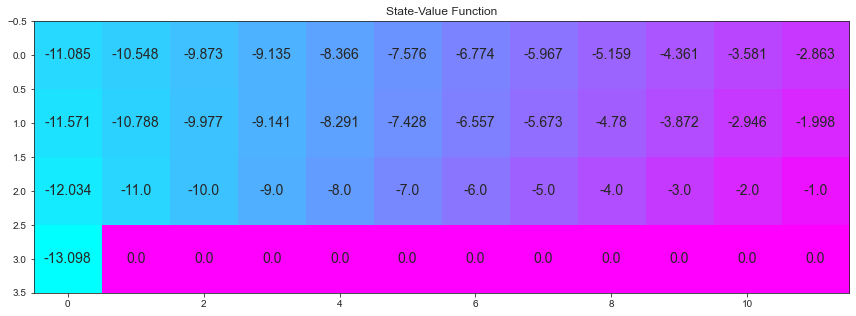

In [139]:
# obtain the estimated optimal policy and corresponding action-value function
#Q_sarsa = sarsa(env, 5000, .01)

# Supplying any eps_decay really doesn't end in Passed test. Supplying 0.99999 default makes it slow as molasses.
#Q_sarsa = sarsa(env, 6000, .01, eps_decay=0.8)

Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [135]:
def generate_episode_q_learning(env, epsilon, Q, alpha, gamma):
    # Initialize S
    state = env.reset()
    
    while True:
        # Choose A from S using policy derived from Q (e.g., "epsilon-greedy)
        action = choose_action_epsilon_greedy_new(Q, state, epsilon)

        # Take action A, observe R, S'
        next_state, reward, done, info = env.step(action)
        
        # Find the action with max Q-value for next_state S'.
        next_state_best_action = get_action_with_highest_reward(Q[next_state])
        best_next_reward = Q[next_state][next_state_best_action] if not done else 0.0
        
        # Update our Q Table for this particular state and action.
        # Q(S, A) <-- Q(S, A) + alpha * (R + (gamma * max(Q(S', a))) - Q(S, A))
        new_q_value = Q[state][action] + alpha * (reward + (gamma * best_next_reward) - Q[state][action])
#        print("new_q_value = ", Q[state][action], " + ", alpha, " * (", reward, " + (", gamma, " * ", expected_next_reward, ") - ", Q[state][action], ") = ", new_q_value)

        # Update Q value
        Q[state][action] = new_q_value
        #print("state: ", state, ", new_q_value: ", new_q_value)

        # S <-- S'
        state = next_state
        
        if done:
            break

In [136]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
        # Trying epsilon decay that matches the solution.
        # NOTE: Where is this different approach to setting epsilon discussed?!!
        epsilon = 1.0 / i_episode

#        print("epsilon: ", epsilon)

        # Generate episode
        generate_episode_q_learning(env, epsilon, Q, alpha, gamma)
        
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  1  2  1  1  1  1  1  1  1  0]
 [ 1  1  0  2  1  1  2  1  1  2  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


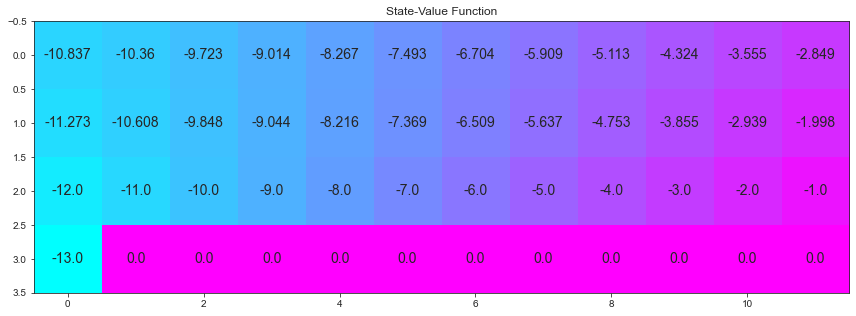

In [140]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [141]:
def get_expected_sarsa_probable_next_reward(actions, epsilon):
    nA = len(actions)
    best_action = get_action_with_highest_reward(actions)
    
    # Compute the probability that we would choose the best action. The probability is calculated as such:
    # 1-eps for the best action.
    # eps / nA for each action at random.
    # In summation, best action = (1-eps) + (eps/nA). Each other action = (eps/nA)
    
    # Initialize an array with length of actions, each with the probability for the action to be chosen randomly.
    probs = np.full(nA, epsilon / nA)
    # Add epsilon-greedy probability to the best choice.
    probs[best_action] += (1.0 - epsilon)
    
    # Multiply each action by the probability it would be selected and return their sum.
    return np.dot(actions, probs)

In [142]:
def test_get_expected_sarsa_probable_next_reward():
    reward = get_expected_sarsa_probable_next_reward(np.arange(12, 16), 0.4)
    # We would expect:
    # best_action index = 3, value = 15
    # [0, 1, 2] would be random choices with probablity of 0.1 each.
    # [3] has probability of 1.0-0.4=0.6 + 0.1 random possibility = 0.7
    # Probable reward = 0.1*12 + 0.1*13 + 0.1*14 + 0.7*15 = 14.4
    print("reward = ", reward)
    
test_get_expected_sarsa_probable_next_reward()

reward =  14.4


In [143]:
def generate_episode_expected_sarsa(env, epsilon, Q, alpha, gamma):
    # Initialize S
    state = env.reset()
    
    while True:
        # Choose A from S using policy derived from Q (e.g., "epsilon-greedy)
        action = choose_action_epsilon_greedy_new(Q, state, epsilon)

        # Take action A, observe R, S'
        next_state, reward, done, info = env.step(action)
        
        probable_next_reward = get_expected_sarsa_probable_next_reward(Q[next_state], epsilon)
        
        # Update our Q Table for this particular state and action.
        # Q(S, A) <-- Q(S, A) + alpha * (R + (gamma * sum_probable_next_reward) - Q(S, A))
        new_q_value = Q[state][action] + alpha * (reward + (gamma * probable_next_reward) - Q[state][action])
#        print("new_q_value = ", Q[state][action], " + ", alpha, " * (", reward, " + (", gamma, " * ", expected_next_reward, ") - ", Q[state][action], ") = ", new_q_value)

        # Update Q value
        Q[state][action] = new_q_value
        #print("state: ", state, ", new_q_value: ", new_q_value)

        # S <-- S'
        state = next_state
        
        if done:
            break

In [144]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(env.nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        
        # Trying epsilon decay that matches the solution.
        # NOTE: Where is this different approach to setting epsilon discussed?!!
        #    Why is this just a set static value?!! 
        epsilon = 0.005

#        print("epsilon: ", epsilon)

        # Generate episode
        generate_episode_expected_sarsa(env, epsilon, Q, alpha, gamma)

    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 10000/10000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  3  1  2  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


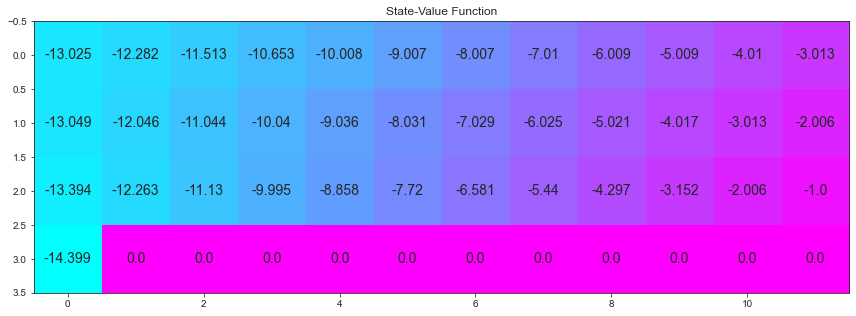

In [145]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])